# pls work

In [1]:
import os

kaggle = False
base_dir = os.getcwd()
print(f"Base directory: {base_dir}")

### UNCOMMENT IF USING KAGGLE/COLAB ###
!pip install librosa pandas 
kaggle = True
data_dir = '/kaggle/input/fma-free-music-archive-small-medium'
###

# !pip install torch==2.6.0 #not needed?

Base directory: /kaggle/working


In [2]:
import pandas as pd
import librosa
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

2.5.1+cu124


In [3]:
import pandas as pd

# import the csv file
directory = data_dir if kaggle else base_dir
file_path = os.path.join(directory, 'fma_metadata', 'tracks.csv')
df_labelconvertion = pd.read_csv(file_path, index_col=1)

# rename columns to actual names
df_labelconvertion.rename(columns={'Unnamed: 0': 'track_id', 'track.7': 'genre_top'}, inplace=True)

# make df of only the important columns
df_labelconvertion = df_labelconvertion[['track_id', 'genre_top']]

# set all NA values to other 
df_labelconvertion['genre_top'] = df_labelconvertion['genre_top'].fillna('Other')

# reset index from albums to normal index
df_labelconvertion = df_labelconvertion.reset_index(drop=True)

# make all values in the track_id column strings
df_labelconvertion['track_id'] = df_labelconvertion['track_id'].astype(str)

# remove first two rows
df_labelconvertion = df_labelconvertion.iloc[2:]


df_labelconvertion


/tmp/ipykernel_31/1240877027.py:6: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df_labelconvertion = pd.read_csv(file_path, index_col=1)


,track_id,genre_top
2,2,Hip-Hop
3,3,Hip-Hop
4,5,Hip-Hop
5,10,Pop
6,20,Other
...,...,...
106571,155316,Rock
106572,155317,Rock
106573,155318,Rock
106574,155319,Rock


In [4]:
# print unique values in the genre_top column
unique_genres = df_labelconvertion['genre_top'].unique()
print(f"Unique genres: {unique_genres}")

Unique genres: ['Hip-Hop' 'Pop' 'Other' 'Rock' 'Experimental' 'Folk' 'Jazz' 'Electronic'
 'Spoken' 'International' 'Soul-RnB' 'Blues' 'Country' 'Classical'
 'Old-Time / Historic' 'Instrumental' 'Easy Listening']


In [5]:
import os

df_labelnumber = pd.DataFrame(columns=['labelnumber', 'unique genres'])
labelnumber = {}
for i, genre in enumerate(unique_genres):
    labelnumber[genre] = i
    
df_labelnumber = pd.DataFrame(labelnumber, index=[0])
# make rows into columns
df_labelnumber = df_labelnumber.transpose()

# save to csv file
os.makedirs("fma_metadata", exist_ok=True)
file_path = os.path.join(base_dir, 'fma_metadata', 'labelnumber.csv')
df_labelnumber.to_csv(file_path, index= True)


In [6]:
df_labelnumbers = pd.read_csv('fma_metadata/labelnumber.csv')

df_labelnumbers.rename(columns={'Unnamed: 0': 'genre', '0': 'number'}, inplace=True)

df_labelnumbers

,genre,number
0,Hip-Hop,0
1,Pop,1
2,Other,2
3,Rock,3
4,Experimental,4
5,Folk,5
6,Jazz,6
7,Electronic,7
8,Spoken,8
9,International,9


In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import torch

class SpectrogramDataset(Dataset):
    def __init__(self, file_paths, sr=44100, n_fft=1024, hop_length=512, window='hann', transform=None):
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.window = window
        self.transform = transform
        self.file_paths = file_paths
                    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        y, sr = librosa.load(file_path, sr=self.sr, mono = True)
        y = y[:10 * self.sr]
        D = librosa.stft(y, n_fft=self.n_fft, hop_length=self.hop_length, window=self.window)
        D_real = np.real(D)
        D_imag = np.imag(D)
        D_real = torch.tensor(D_real, dtype=torch.float32)
        D_imag = torch.tensor(D_imag, dtype=torch.float32)
        
        # concat real and imaginary parts to 2 channels
        D = torch.stack((D_real, D_imag), dim=0)
        # get the label from the file name and convert to genre
        track_id = os.path.basename(file_path).replace('.mp3', '').lstrip('0')
        # try to get the label from the dataframe
        try:
            # label = df_labelconvertion.query('track_id == @track_id')['genre_top'].values[0]
            label = df_labelconvertion.query('track_id == @track_id')['genre_top'].values[0]
            label = torch.tensor(df_labelnumbers.query('genre == @label')['number'].values[0])
        except IndexError:
            # if not found, set label to 'Other'
            print(f"Track ID: {track_id} not found in dataframe")
            label = 'Other'
        
        return D, label

In [8]:
file_directory = os.path.join(directory, 'fma_small', 'fma_small')

# create dataloader
batch_size = 32
num_workers = 4

# train test split
from sklearn.model_selection import train_test_split
import soundfile as sf

# get all file paths
file_paths = []
for root, _, files in os.walk(file_directory):
    for file in files:
        if file.endswith('.mp3'):
            file_paths.append(os.path.join(root, file))
            
# split the file paths into train and test
train_paths, test_paths = train_test_split(file_paths, test_size=0.2, random_state=42)

# find if any song is shorter than 10 seconds or is corrupted
min_duration = 10
for path in train_paths:
    try:
        info = sf.info(path)
        duration = info.frames / info.samplerate
        if duration < min_duration:
            print(f"{path} is too short: {duration:.2f}s")
            train_paths.remove(path)
    except Exception as e:
        print(f"File {path} is corrupted: {e}")
        train_paths.remove(path)
        
for path in test_paths:
    try:
        info = sf.info(path)
        duration = info.frames / info.samplerate
        if duration < min_duration:
            print(f"{path} is too short: {duration:.2f}s")
            test_paths.remove(path)
    except Exception as e:
        print(f"File {path} is corrupted: {e}")
        test_paths.remove(path)


/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/098/098565.mp3 is too short: 1.63s
File /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/133/133297.mp3 is corrupted: Error opening '/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/133/133297.mp3': File does not exist or is not a regular file (possibly a pipe?).


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


File /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/099/099134.mp3 is corrupted: Error opening '/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/099/099134.mp3': File does not exist or is not a regular file (possibly a pipe?).
/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/098/098567.mp3 is too short: 0.54s
File /kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3 is corrupted: Error opening '/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/108/108925.mp3': File does not exist or is not a regular file (possibly a pipe?).


[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small/098/098569.mp3 is too short: 1.56s


In [9]:
train_dataset = SpectrogramDataset(train_paths)
test_dataset = SpectrogramDataset(test_paths)

num_workers = 4 if kaggle else 0
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=kaggle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=kaggle)

In [10]:
# check the shape of the data
# for batch in train_dataloader:
#     print(batch[0].shape)
#     print(batch[1].shape)
#     break

In [12]:
import sys

if kaggle:
    sys.path.append('/kaggle/input/cvae-actual-i-think')

import cvae_actual_i_think
import importlib
importlib.reload(cvae_actual_i_think) # Reload the cvae module to ensure it's up to date

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

model = cvae_actual_i_think.ConvCVAEPL()

# Logger for saving training metrics
logger = CSVLogger("logs", name="cvae_training_metrics")

# Checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    # save best model
    # filename="best_model",
    # save_top_k=1,

    #save every n:th model
    filename="{epoch:02d}-{val_loss:.2f}",
    save_top_k=-1,
    every_n_epochs=5,
    save_last=True, #TODO: not tested if ok
    
    save_weights_only=False,
)

os.makedirs("checkpoints", exist_ok=True)

# Early stopping callback to stop training when validation loss doesn't improve
early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)

# Initialize the PyTorch Lightning Trainer
trainer = Trainer(
    max_epochs=20, 
    accelerator="auto", 
    devices=1, 
    logger=logger, 
    callbacks=[checkpoint_callback, early_stop_callback])


# Train the model
import time

start_time = time.time()
print("Training started")

trainer.fit(model, train_dataloader, test_dataloader)
print("Training finished")
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

Training started


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Beta = 0.023


[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


Validation: |          | 0/? [00:00<?, ?it/s]

Beta = 0.027


[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!


Validation: |          | 0/? [00:00<?, ?it/s]

Beta = 0.031


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)


Validation: |          | 0/? [00:00<?, ?it/s]

Beta = 0.036


[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!


Validation: |          | 0/? [00:00<?, ?it/s]

Beta = 0.041


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)


Validation: |          | 0/? [00:00<?, ?it/s]

Beta = 0.047


[src/libmpg123/layer3.c:INT123_do_layer3():1844] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3328) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1774] error: part2_3_length (3360) too large for available bit count (3240)


Validation: |          | 0/? [00:00<?, ?it/s]

Training finished
Training time: 2095.138190984726 seconds


## Plot training data

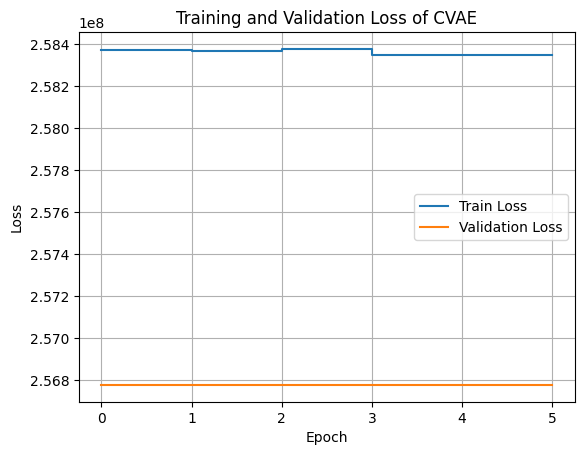

In [15]:
import matplotlib.pyplot as plt

metrics = pd.read_csv(os.path.join(logger.log_dir, "metrics.csv")).ffill()

def plot_training_metrics(metrics):
    """Plot training metrics by epoch."""

    plt.plot(metrics["epoch"], metrics["train_loss"], label="Train Loss")
    plt.plot(metrics["epoch"], metrics["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss of CVAE")
    plt.grid()
    plt.legend()
    
    plt.show()

plot_training_metrics(metrics)

In [ ]:
# model = cvae_actual_i_think.ConvCVAEPL.load_from_checkpoint("checkpoints/.ckpt")

## Generate samples

In [27]:
import numpy as np

importlib.reload(cvae_actual_i_think) # Reload the cvae module to ensure it's up to date

label = np.array([1])
z = np.random.rand(1,model.model.latent_size)*6-3

print(torch.from_numpy(z).float())
print(torch.from_numpy(label))

# device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
# print(device)
print(model.device)

z = torch.from_numpy(z).float().to(model.device)
labels = torch.tensor(label).to(model.device)
generated_images = model.model.sample(z, labels)

plt.imshow(generated_images[0][0].detach().cpu().numpy(), cmap="gray")
plt.show()


tensor([[ 0.1539, -2.0388,  1.9213, -2.1220,  1.2511, -1.5847, -1.4554,  1.3772,
         -0.2831,  1.7264,  0.2929, -2.2215, -2.8578,  2.0434,  0.8179, -0.6722,
          2.4981, -0.3645, -1.1016,  0.3580, -2.4338,  1.3630, -2.5296,  0.4294,
          0.2804, -1.4646,  1.1898,  0.5748,  1.0333,  1.8372]])
tensor([1])
cpu


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)